In [1]:
import os
if os.name != 'posix':
    %matplotlib ipympl
else:
    %matplotlib notebook
import scipy.constants as sc
from scipy.optimize import fsolve

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py

print(os.getpid())
%cd ../

colors_ = ["blue", "red", "green", "gray", "black"]

import pylib.mix as mix
import pylib.measurement as mse
import pylib.qsvt_angles as qsvt_a
import cvxpy as cp

25896
C:\Users\novikau1\Documents\work\codes\QuCF\scripts-py


In [2]:
for i in range(30):
    plt.close()

In [3]:
def reproduce_env(x, a):
    Nx = len(x)
    res_pol = np.zeros(Nx)
    Nc = len(a)
    for ix in range(Nx):
        res_pol[ix] = 0.
        for ii in range(Nc):
            res_pol[ix] += a[ii] * np.cos((2*ii) * np.arccos(x[ix]))
    return res_pol


def include_sign(half_env):
    N_env = len(half_env)
    Nh = 2*N_env
    phis_half = np.zeros(Nh)

    counter_el = -1
    for ii in range(N_env-1):
        v1 = half_env[N_env - ii - 1]

        counter_el += 1
        phis_half[Nh-counter_el-1] = v1

        counter_el += 1
        v2 = half_env[N_env - ii - 2]
        phis_half[Nh-counter_el-1] = -(v1+v2)/2.
    return phis_half


def compute_inverse_function(phis_comp, kappa, coef_norm):
    # ---------------------------------------------------
    def compute_inverse_function_at_x1(x1):
        # - W-matrix -
        xs = 1j*np.sqrt(1 - x1**2)
        W = np.array([
            [x1, xs],
            [xs, x1]
        ], dtype = complex)

        # - sequence of rotations -
        U = np.array(Rphi[0])
        for ia in range(1,Na):
            U = U.dot(W).dot(Rphi[ia])
        return U[0,0].real
    # ---------------------------------------------------
    Na = len(phis_comp)

    # x-grid:
    Nx = Na*2
    x_grid_1 = np.linspace(-1.0, -1.0/kappa)
    x_grid_2 = np.linspace(1.0/kappa, 1.0, Nx)
    x_grid = np.concatenate((x_grid_1, x_grid_2))
    Nx = len(x_grid)

    # rotation matrices:
    Rphi = np.zeros((Na,2,2), dtype = complex)
    for ia in range(Na):
        ephi = np.exp(1j * phis_comp[ia])
        Rphi[ia,0,0] = ephi
        Rphi[ia,1,1] = np.conjugate(ephi)

    # computation:
    inv_qsvt = np.zeros(Nx)
    for ix in range(Nx):
        inv_qsvt[ix] = compute_inverse_function_at_x1(x_grid[ix])
    inv_qsvt *= kappa * coef_norm

    # --- the reference case ---
    inv_ref = 1./x_grid

    return inv_qsvt, inv_ref, x_grid

In [7]:
# ----------------------------------------------------------------------------------
# --- Read the coefficients to estimate the QSVT angles for the matrix inversion ---
# ----------------------------------------------------------------------------------
def read_data(full_fname):
    dd = {}
    print("Reading the coefficients from:\n " + full_fname)
    with h5py.File(full_fname, "r") as f:
        grp = f["basic"]
        date_comp = grp["date-of-simulation"][()].decode("utf-8")
        dd["factor-norm"] = grp["coef_norm"][()]
        line_descr = grp["descr"][()].decode("utf-8")
        dd["kappa"] = grp["param-ref"][()]
        dd["N-env-half"] = int(grp['N-env-half'][()])

        grp = f["coefs-amplitude"]
        dd["coefs-A"] = np.array(grp["real"])

        grp = f["coefs-shape"]
        dd["coefs-shape"] = np.array(grp["real"])
    # ---
    print("When simulated: ", date_comp)
    print("Data {:s}".format(line_descr))
    print("kappa: {:0.3f}".format(dd["kappa"]))
    print("factor-norm: {:0.3f}".format(dd["factor-norm"]))
    print("N-env-half: {:d}".format(dd["N-env-half"]))
    print("N-coefs-shape: {:d}".format(len(dd["coefs-shape"])))
    return dd
# -----------------------------------------------------------------
path_root_ ="./tools/estimation-QSVT-MI-coefs/"
fname_ = "QSVT-MI-estimation-coefs.hdf5"
full_fname = path_root_ + "/" + fname_

dd_ = read_data(full_fname)

Reading the coefficients from:
 ./tools/estimation-QSVT-MI-coefs//QSVT-MI-estimation-coefs.hdf5
When simulated:  01/17/2024: 15:47:44
Data for-inversion
kappa: 100.000
factor-norm: 0.125
N-env-half: 563
N-coefs-shape: 10


In [13]:
# -------------------------------------------------------------
# --- Parameters for the estimation of the matrix inversion ---
# -------------------------------------------------------------

# chosen condition number:
kappa_qsvt_ = 200.

# normalization coefficient:
coef_norm_ = 1./ dd_["factor-norm"]

# parameters for the reconstruction of the QSVT angles:
coefs_shape_ = dd_["coefs-shape"]

# the coefficient to compute the half of the positive peak of QSVT angles:
coef_Na_  = dd_["N-env-half"]/dd_["kappa"]

# the coefficient to comput the maximum amplitude of the QSVT angles:
coefs_A_  = dd_["coefs-A"]

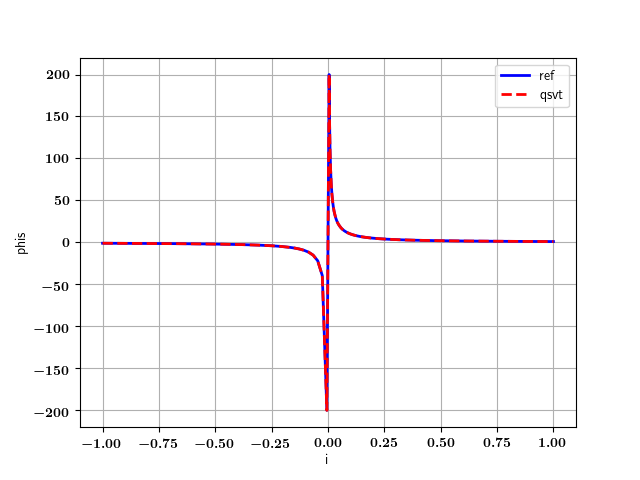

max. abs. err: 2.457e-01


In [14]:
# ------------------------------------------------------------------------------
# --- Estimate the QSVT angles ---
# ------------------------------------------------------------------------------

# - the number of peaks in the QSVT angles -
N_env = int(coef_Na_ * kappa_qsvt_)
grid_xa = np.linspace(0.0, 1.0, N_env)

# - Absolute amplitudes of the QSVT angles -
half_env = reproduce_env(grid_xa, coefs_shape_)
del grid_xa

# - Include the sign of the QSVT angels -
phis_half = include_sign(half_env)
phis_appr = np.concatenate(( phis_half, np.flip(phis_half) ))

# - Rescale the QSVT angles -
max_ampl = coefs_A_[0]
for ii in range(1, len(coefs_A_)):
    max_ampl += coefs_A_[ii] / kappa_qsvt_**ii
phis_appr *= np.abs(max_ampl)

# --- Compute the inverse function using the sequence of 2x2 rotations ---
# - Correct the angles to compute the inverse function -
phis_appr[0]  += np.pi/4.
phis_appr[-1] += np.pi/4.

# - the refence inverse function -
inv_qsvt, inv_ref, x_grid = compute_inverse_function(
    phis_appr, kappa_qsvt_, coef_norm_
)

# - Plot the inverse function -
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_grid, inv_ref,  color="b", linewidth = 2, linestyle='-',  label = "ref")
ax.plot(x_grid, inv_qsvt, color="r", linewidth = 2, linestyle='--', label = "qsvt")
plt.xlabel('i')
plt.ylabel("phis")
# plt.xlim(-5, 5)
ax.legend()
plt.grid(True)
plt.show()

N = len(inv_qsvt)
rr = range(0, N)
max_abs_err = np.max(np.abs(inv_qsvt[rr] - inv_ref[rr]))
print("max. abs. err: {:0.3e}".format(max_abs_err))

del inv_qsvt, inv_ref, x_grid

In [10]:
# ----------------------------------------------------------------
# --- Store the QSVT angles to .hdf5 file ---
# ----------------------------------------------------------------
# The stored angles can be use to compute the matrix inversion
# using the QSVT circuit.
# ---
# The condition number of the target matrix should be of the order of
# the parameter kappa_qsvt_.
# ----------------------------------------------------------------

# - Correct the QSVT angles -
phis_save = np.array(phis_appr)
phis_save[0]  -= np.pi/4.
phis_save[-1] -= np.pi/4.
phis_save     += np.pi/2.

# - Store the QSVT angles -

# !!! Use the same structure of the .hdf5 file as uses in usual .hdf5 files with the QSVT angles !!!

In [11]:
# -----------------------------------------
# --- Read data ----
# -----------------------------------------
mix.reload_module(qsvt_a)

path_coef_ = "./tools/QSVT-angles/inversion/"
filenames_ = [
    # ---
    "k5_eps3.hdf5",    # id = 0
    "k10_eps3.hdf5",   # id = 1 
    "k40_eps3.hdf5",   # id = 2 
    "k80_eps3.hdf5",   # id = 3 
    "k100_eps3.hdf5",  # id = 4
    # ---
    "k5_eps14.hdf5",   # id = 5 
    "k10_eps14.hdf5"   # id = 6
]

# where the computed coefficients should be saved ---
path_root_ ="./tools/estimation-QSVT-MI-coefs/"
fname_ = "QSVT-MI-estimation-coefs.hdf5"

# read the QSVT angles computed using the L-BFGS approach [Dong-21-DOI:10.1103/PhysRevA.103.042419]:
dds_ = []
for ii in range(len(filenames_)):
    print("\n----------------------------------------")
    dds_.append(qsvt_a.read_angles(path_coef_, filenames_[ii]))
del ii


----------------------------------------
Reading angles from the file 
./tools/QSVT-angles/inversion//k5_eps3.hdf5
when simulated:  01-15-2024 14:55:13

function-type: 		inv
function-parity: 		1
param: 			5.000000
absolute error: 	3.554e-04
norm. factor: 		1.250e-01
Number of angles: 	112

----------------------------------------
Reading angles from the file 
./tools/QSVT-angles/inversion//k10_eps3.hdf5
when simulated:  01-15-2024 14:54:49

function-type: 		inv
function-parity: 		1
param: 			10.000000
absolute error: 	3.516e-04
norm. factor: 		1.250e-01
Number of angles: 	224

----------------------------------------
Reading angles from the file 
./tools/QSVT-angles/inversion//k40_eps3.hdf5
when simulated:  01-15-2024 14:33:08

function-type: 		inv
function-parity: 		1
param: 			40.000000
absolute error: 	1.689e-04
norm. factor: 		1.250e-01
Number of angles: 	900

----------------------------------------
Reading angles from the file 
./tools/QSVT-angles/inversion//k80_eps3.hdf5
when s

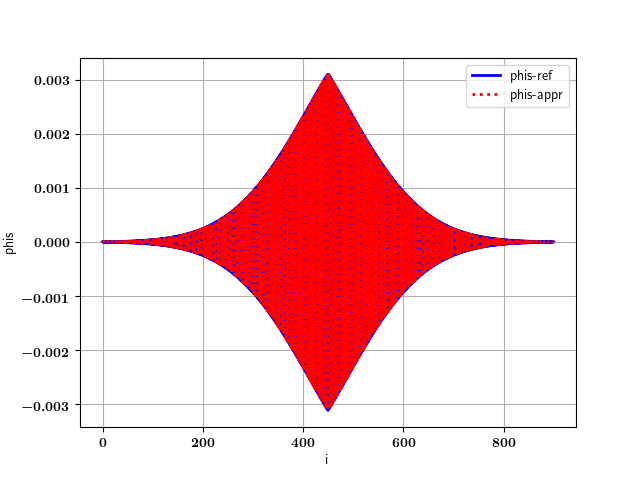

In [12]:
# --- plot angles ---
range_full = np.array(range(len(phis_save)))


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range_full, dds_[2]["phis"] - np.pi/2,  color="b", linewidth = 2, linestyle='-', label = "phis-ref")
ax.plot(range_full, phis_save - np.pi/2.,       color="r", linewidth = 2, linestyle=':', label = "phis-appr")
plt.xlabel('i')
plt.ylabel("phis")
# plt.xlim([-50, 50])
ax.legend()
plt.grid(True)
plt.show()